### Initial playground for domain adaptation and moving into active learning

* Paul Blankley 

In [51]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch 
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import pyro

%matplotlib inline

In [58]:
def _get_samplers(total_len,init_size,val_size=10000, random_seed=1492):
    """ Get docs at some point, but this basically just get the samplers for initialization"""
    if random_seed:
        np.random.seed(random_seed)
    # Get Indices for validation and for initial random training sample
    idxs = list(range(len(train_set)))
    val_idx = np.random.choice(idxs,size=val_size, replace=False)
    train_idx = list(set(idxs)-set(val_idx))
    init_labels_idx = np.random.choice(train_idx,size=init_size, replace=False)
    unlabeled_idx = list(set(idxs)-set(init_labels_idx))
    
    # Get samplers for torch
    val_sampler = SubsetRandomSampler(val_idx)
    train_sampler = SubsetRandomSampler(init_labels_idx)
    unlabeled_sampler =  SubsetRandomSampler(unlabeled_idx)
    return train_sampler, unlabeled_sampler, val_sampler, init_labels_idx, unlabeled_idx

# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=8, starting_size=64, val_size=10000, use_cuda=False):
    root = './data'
    download = True
    trans = transforms.ToTensor()
    train_set = dset.MNIST(root=root, train=True, transform=trans,
                           download=download)
    test_set = dset.MNIST(root=root, train=False, transform=trans)

    tr_samp, unlab_samp, val_samp, init_idx, unlab_idx = _get_samplers(len(train_set), starting_size, val_size)
    
    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, \
                                               sampler=tr_samp, **kwargs)
    unlab_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=len(unlab_idx), \
                                               sampler=unlab_samp, **kwargs)
    val_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=val_size, \
                                             sampler=val_samp, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=len(test_set), \
                                              shuffle=False, **kwargs)
    return (train_loader, unlab_loader, val_loader, test_loader), init_idx, unlab_idx



In [59]:
######## SET PARAMS ##########
batch_size = 8
start_size = 64

##############################

# Get raw datasets 
train_set = dset.MNIST(root='./data', train=True, transform=transforms.ToTensor(),download=False)
test_set = dset.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Get loaders and initial indices
loaders, init_idx, unlab_idx = setup_data_loaders(batch_size=batch_size, starting_size=start_size, use_cuda=False)
train_loader, unlab_loader, val_loader, test_loader = loaders

In [67]:
# Get the x,y seperation
def get_xy_split(loader):
    """ Get the x/y split for a dataloader """
    temp_x,temp_y = [],[]
    for tx,ty in loader:
        temp_x.append(tx)
        temp_y.append(ty)
    return torch.cat(temp_x), torch.cat(temp_y)

# Get dataloader from sets of inidces
def get_dataloader(labels_idx, new_labels_idx, batch_size=8, base_data=train_set):
    """ This method takes in the old indices and the new indices requested by the model and 
    generates a dataloader based on the union of the set of the two arrays of indices."""
    all_labels_idx = np.append(labels_idx, new_labels_idx)
    new_sampler = SubsetRandomSampler(all_labels_idx)
    new_loader = torch.utils.data.DataLoader(dataset=base_data, batch_size=batch_size, sampler=new_sampler)
    return new_loader 

# Accuracy 
def accuracy(model,x,y):
    """ Get classification accuracy """
    probs = model.forward((Variable(x)))
    _,ypred = torch.max(probs,1)
    acc = (ypred.data.numpy()==y.numpy()).sum()/len(y)
    return acc
  

In [68]:
# Get x/y split for the validation and test sets 
val_x,val_y = get_xy_split(val_loader)
test_x,test_y = get_xy_split(test_loader)


### Idea:

You start with 64 random points to make a model. Then you get to choose 16 points to have the labels given to you.  Just pass a policy function that decides which policy to follow to get the new points.  Then compare the two policies and show that the "active learning" (with intelligent policy performs better).

In [85]:
# Define the model
class logreg(nn.Module):
    """ Logistic regression """
    def __init__(self, classes):
        super(logreg, self).__init__()
        self.classes = classes
        self.w = nn.Linear(28*28,classes)
        
    def forward(self, x):
        x = self.w(x.view(-1,1,28*28))
        return x.view(-1,self.classes)


def train_model(model, data_loader, loss_func, optimizer, epochs=10):
    """ Function to train the model """
    losses,itrs = [],0

    for epoch in tqdm(range(epochs)):
        for i,(batch_x,batch_y) in enumerate(data_loader):
            batch_x = Variable(batch_x)
            batch_y = Variable(batch_y)

            y_pred = model(batch_x)
            loss = loss_func(y_pred, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            itrs+=1
            losses.append(loss.data.numpy()[0])
            
    # For plotting 
    return range(itrs), losses
        
    
def get_requested_points(model, unlab_loader, policy, num_points=16):
    unlab_preds = model(unlab_loader)
    return policy(unlab_preds, num_points)




model = logreg(classes=10)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=.01)

plot_itr, plot_loss = train_model(model, train_loader, loss_func, optimizer)

A Jupyter Widget

In [81]:
test_get_requested_points()

In [84]:
torch.Tensor(np.array([[1,2,3],[7,7,7]])), torch.Tensor(np.array([1,2]))

(
  1  2  3
  7  7  7
 [torch.FloatTensor of size 2x3], 
  1
  2
 [torch.FloatTensor of size 2])

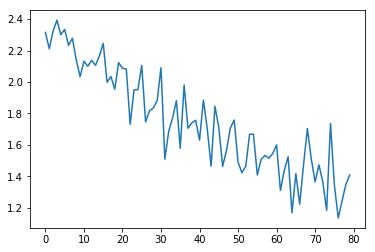

In [71]:
plt.plot(plot_itr,plot_loss)

In [72]:
acc_val = accuracy(model,val_x,val_y)
print('Accuracy on the validation set:',acc_val)

Accuracy on the validation set: 0.4947


In [73]:
print(model)

logreg(
  (w): Linear(in_features=784, out_features=10)
)


In [91]:
np.random.uniform(size=(3,2)) @ np.random.poisson(size=(2,6))

array([[ 0.42717293,  3.19764252,  0.14239098,  0.28478196,  2.226689  ,
         0.        ],
       [ 2.78756705,  2.18186078,  0.92918902,  1.85837803,  2.0740332 ,
         0.        ],
       [ 0.02217952,  0.13475335,  0.00739317,  0.01478635,  0.09476435,
         0.        ]])